In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import netCDF4
from scipy import stats
import statsmodels.api as sm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('/Users/gbromley/Dropbox/code/python_utilities/')
from python_data_functions import extract_months
from python_met_functions import sat_vap_pres
from python_data_functions import mk_test
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText



/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
data_dir = '/Users/gbromley/Dropbox/CRUTS4.01/'
output_dir='/Users/gbromley/code/NGP_Climate/'
temp_file = 'cru_ts4.01.1901.2016.pre.dat.nc'
#vap_file = 'vap/cru_ts3.24.1901.2015.vap.dat.nc'
#nc_vap = xr.open_dataset(data_dir+vap_file)
nc_temp = xr.open_dataset(data_dir+temp_file)


In [ ]:
nc_temp

In [4]:
t2m = nc_temp['pre']


In [ ]:
def trend_calc(x_array,axis):
    #x_array = x.values
    print(x_array)
    base = np.linspace(0,len(x_array),len(x_array)+1)
    base = sm.add_constant(base)
    print(len(x_array))
    print(len(base))
    model = sm.OLS(x_array,base)
    trend = model.fit().params[1]
    
    return trend
    

In [5]:
#t_season='AMJ'
#t_months=[4,5,6]
start_year = '1970-01-01'
end_year = '2015-12-01'
ext_e = -92
ext_w = -120
ext_n = 55
ext_s = 38
t2m = t2m.sel(lat=slice(ext_s-5,ext_n+5),lon=slice(ext_w-5,ext_e+5))
#ggw_lat,ggw_lon = 48.18, -106.635

In [ ]:
t2m_slice=t2m.sel(time=slice(start_year,end_year))

In [6]:
#extract the time period we are interested in
t2m_slice=t2m.sel(time=slice(start_year,end_year))


#extract the 30 yr climate normal times
t2m_clim_30= t2m.sel(time=slice('1980-01-01','2011-01-01'))

#create averages over months for climate normal
t2m_clim_months_avg = t2m_clim_30.groupby('time.season').mean(dim='time')

In [7]:
t2m_slice = t2m_slice.groupby('time.season').apply(lambda x: x.groupby('time.year').mean(dim='time'))

In [8]:
anom = t2m_slice - t2m_clim_months_avg

In [9]:
anom.season

<xarray.DataArray 'season' (season: 4)>
array(['DJF', 'JJA', 'MAM', 'SON'], dtype=object)
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [ ]:
anom

In [13]:
#create 2d structure to hold slope
season = ['DJF','JJA','MAM','SON']
lat = t2m.lat
lon=t2m.lon
spatial_trend = xr.DataArray(np.random.rand(4,54,76),coords=[season,lat,lon],dims=['season','lat','lon'])
spatial_trend.name = 't2m_trend'
spatial_trend.attrs['units'] = 'C per Decade'
spatial_trend.attrs['long_name'] = '2 meter temperature trend'



slope_scipy = t2m.isel(time=1).copy(deep=True)
#create 2d structure to hold pvalues
lat = t2m.lat
lon=t2m.lon
pvalues = xr.DataArray(np.random.rand(4,54,76),coords=[season,lat,lon],dims=['season','lat','lon'])
pvalues.name = 't2m_trend_pvalues'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] = '2 meter temperature trend pvalues'

In [ ]:
spatial_trend

In [67]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
corr_vals = np.arange(0,len(anom.year))
corr_vals = sm.add_constant(corr_vals)
for k in np.arange(0,4):
    for i in np.arange(0,len(anom['lat'])):
        for j in np.arange(0,len(anom['lon'])):
            series = anom[k,i,j,:]
            model = sm.OLS(series.values,corr_vals)
            ac_coe = sm.tsa.stattools.acf(series.values)
            model = sm.OLS(series.values,corr_vals)
            #slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(corr_vals,anom.values)
            results = model.fit()
            slope = results.params[1]
            adjusted_error = results.bse[1] * (np.sqrt((1-ac_coe[1])/(1+ac_coe[1])))
            t_value = ((slope)/adjusted_error)
            #two-sided
            p_value = 2*(1-stats.t.cdf(abs(t_value), results.df_resid))
            #t_value = ((slope - 0.02)/results.bse[1])
            #p_value = stats.t.cdf(t_value, results.df_resid)
            #p_value = stats.t.sf(results.tvalues[0], results.df_resid)
            spatial_trend[k,i,j]=slope*10
            #slope_scipy[i,j] = slope_2*10
            pvalues[k,i,j]= p_value

/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:475: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


In [71]:
pvals = pvalues.where(pvalues.values < 0.05)

/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


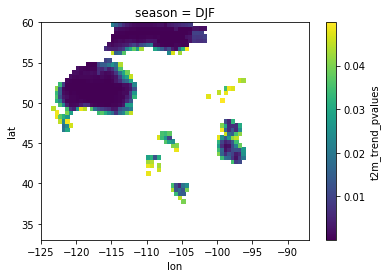

In [72]:
pvals[0,:,:].plot()

In [31]:
pvals.to_netcdf(data_dir+'pvals_temp_clim_season_2_27_18.nc')

In [ ]:
#spatial_trend.to_dataset().to_netcdf(data_dir+'CRU_temp_tobias'+t_season+'_'+'1970'+'.nc')

In [ ]:
pvalues.to_dataset().to_netcdf(t_season+'_1970_pvalues.nc')

/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'axes', 'color', 'edgecolor'
  s)


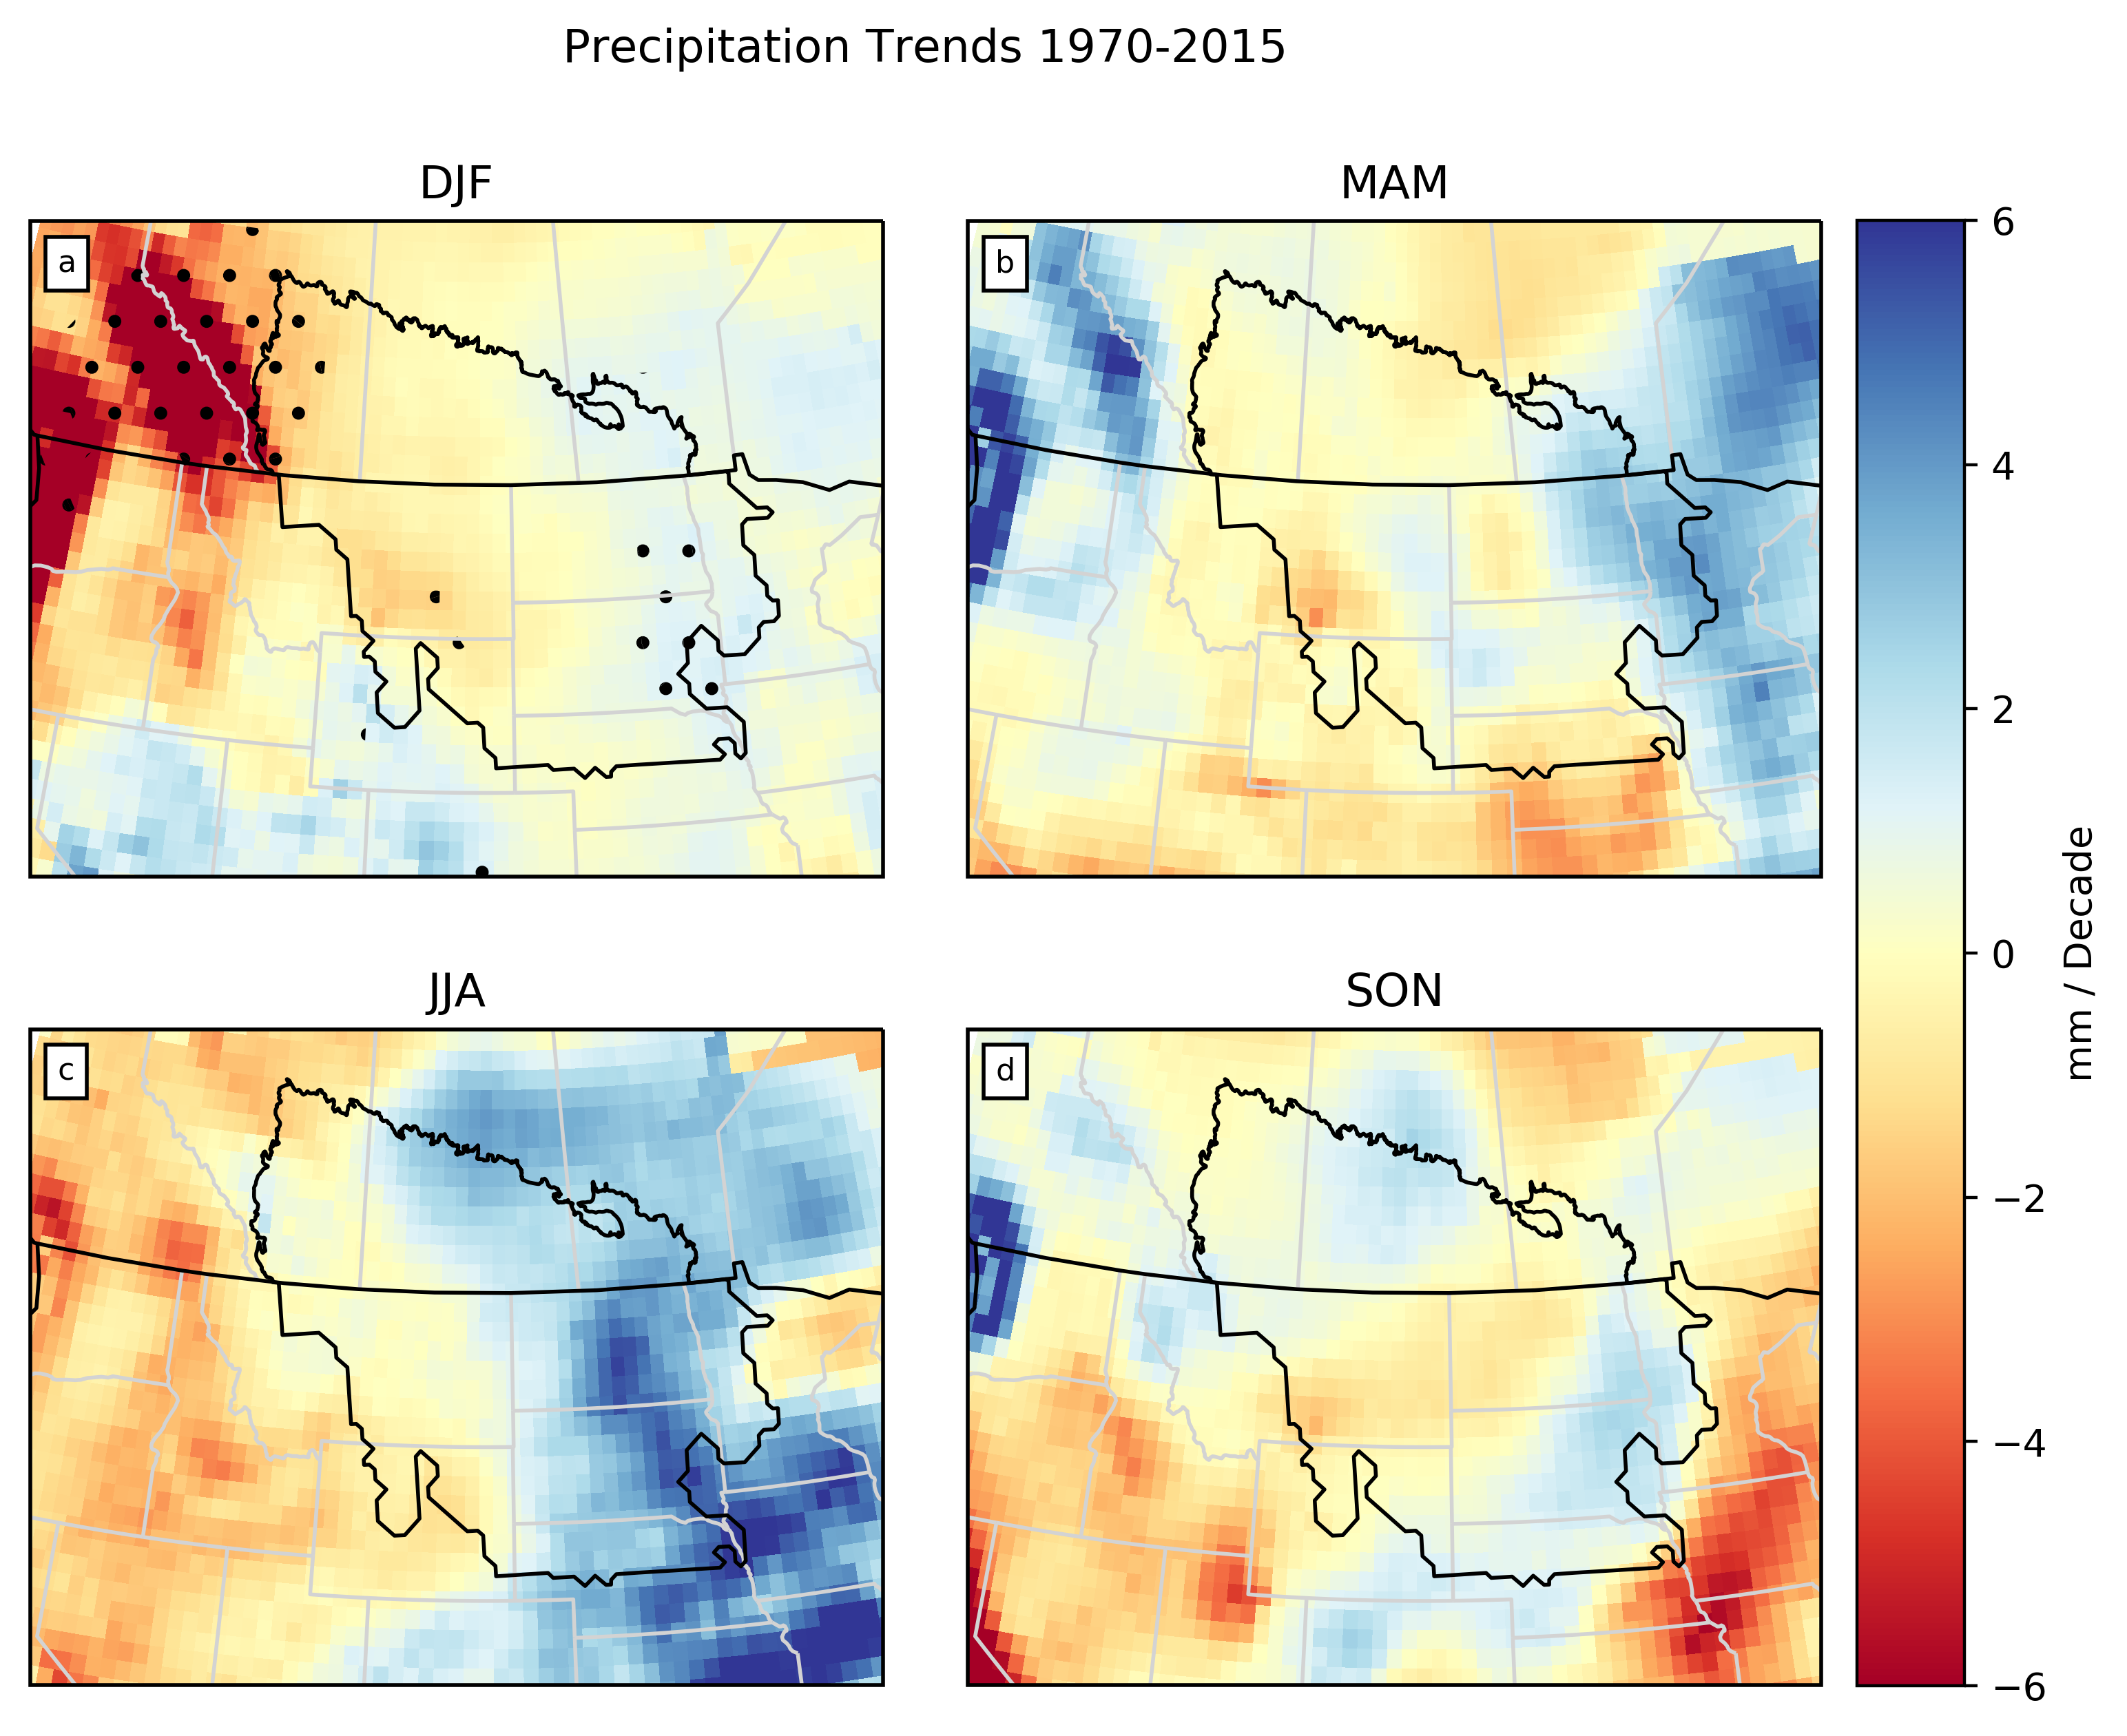

In [73]:
#create figure
cb_min = -6
cb_max = 6
fig = plt.figure(1,figsize=(13,7), dpi=400.0)
#create projection
projection = ccrs.LambertConformal(central_longitude=-105,central_latitude=45,standard_parallels=[50,40])
ax1 = plt.subplot(2,2,1, projection = projection)

cb = plt.pcolormesh(spatial_trend.lon,spatial_trend.lat,spatial_trend[0,:,:].values,transform=ccrs.PlateCarree(),vmin=cb_min, vmax=cb_max, cmap='RdBu')
#pvals[0,:,:].plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches="..",alpha=0.,add_colorbar = False)
ax1.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces, edgecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
shape_feature = ShapelyFeature(Reader('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/Study_Area_08_01_17.shp').geometries(),crs=ccrs.PlateCarree(), facecolor='none',edgecolor='black')
ax1.add_feature(shape_feature)
ax1.title.set_text('DJF')
at = AnchoredText("a",
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  #backgroundcolor = 'lightgray'
                  )
ax1.add_artist(at)

ax2 = plt.subplot(2,2,2, projection = projection)
ax2.set_title('MAM')
plt.pcolormesh(spatial_trend.lon,spatial_trend.lat,spatial_trend[2,:,:].values,transform=ccrs.PlateCarree(),vmin=cb_min, vmax=cb_max, cmap='RdBu')

ax2.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax2.add_feature(states_provinces, edgecolor='lightgray')
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(shape_feature)
bt = AnchoredText("b",
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  #backgroundcolor = 'lightgray'
                  )
ax2.add_artist(bt)
#ax2.title.set_visible(False)

ax3 = plt.subplot(2,2,3, projection = projection)
ax3.set_title('JJA')
plt.pcolormesh(spatial_trend.lon,spatial_trend.lat,spatial_trend[1,:,:].values,transform=ccrs.PlateCarree(),vmin=cb_min, vmax=cb_max, cmap='RdBu')
#ax = plt.axes(projection=ccrs.LambertConformal())
#pvals.plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches="..",alpha=0.,add_colorbar = False)
ax3.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax3.add_feature(states_provinces, edgecolor='lightgray')
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS)
ax3.add_feature(shape_feature)
ct = AnchoredText("c",
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  #backgroundcolor = 'lightgray'
                  )
ax3.add_artist(ct)


ax4 = plt.subplot(2,2,4, projection = projection)
ax4.set_title('SON')
plt.pcolormesh(spatial_trend.lon,spatial_trend.lat,spatial_trend[3,:,:].values,transform=ccrs.PlateCarree(),vmin=cb_min, vmax=cb_max, cmap='RdBu')
#ax = plt.axes(projection=ccrs.LambertConformal())
#pvals.plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches="..",alpha=0.,add_colorbar = False)
ax4.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax4.add_feature(states_provinces, edgecolor='lightgray')
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS)
ax4.add_feature(shape_feature)
dt = AnchoredText("d",
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  #backgroundcolor = 'lightgray'
                  )
ax4.add_artist(dt)
fig.subplots_adjust(top=0.9,bottom=0.1,left=0.25,right=0.75,hspace=0.1,wspace=0.1)
fig.suptitle('Precipitation Trends 1970-2015')
cax = fig.add_axes((0.76, 0.12, 0.03, 0.76))
col_bar = fig.colorbar(cb,cax=cax)
col_bar.set_label('mm / Decade',fontsize=10)

#plt.tight_layout()
#plt.savefig('/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/four_panel_precip.png',bbox_inches='tight')
plt.show()


In [52]:
ax2.get_position()

Bbox([[0.5119047619047619, 0.5395088492229407], [0.75, 0.8795387698246783]])

In [53]:
ax4.get_position()

Bbox([[0.5119047619047619, 0.12046123017532179], [0.75, 0.4604911507770593]])

In [55]:
0.12+0.54

0.66

In [67]:
shape_feature


TypeError: intersecting_geometries() missing 1 required positional argument: 'extent'